# Sequence Processing with HMMs and CRFs

**The goal of this practical is to study sequence models in NLP.**

We will work on Part-Of-Speech (POS) and optionally on chunking (gathering different groups in sentences). The datasets are from [CONLL 2000](https://www.clips.uantwerpen.be/conll2000/chunking/): 
- **Small corpus:** chtrain/chtest to understand the tools and models 
- **Larger corpus:** train/test to collect reliable experimental results


# 1) HMMS


In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Loading POS/Chunking data
def load(filename):
    listeDoc = list()
    with open(filename, "r") as f:
        doc = list()
        for ligne in f:
            if len(ligne) < 2: # fin de doc
                listeDoc.append(doc)
                doc = list()
                continue
            mots = ligne.replace("\n","").split(" ")
            doc.append((mots[0],mots[1])) # Change mots[1] -> mots[2] for chuncking
    return listeDoc

In [4]:
# =============== loding ============
# small corpus => ideal for first tests
filename = "./chtrain.txt" 
filenameT = "./chtest.txt" 

# Larger corpus => To valide perf.
# filename = "ressources/conll2000/train.txt" 
# filenameT = "ressources/conll2000/test.txt" 

alldocs = load(filename)
alldocsT = load(filenameT)

print(len(alldocs)," docs read")
print(len(alldocsT)," docs (T) read")

823  docs read
77  docs (T) read


In [11]:
print(alldocs[0])
print(alldocsT[0])
nb_mots_test = sum([len(doc) for doc in alldocsT])
print(nb_mots_test)

[('Rockwell', 'NNP'), ('International', 'NNP'), ('Corp.', 'NNP'), ("'s", 'POS'), ('Tulsa', 'NNP'), ('unit', 'NN'), ('said', 'VBD'), ('it', 'PRP'), ('signed', 'VBD'), ('a', 'DT'), ('tentative', 'JJ'), ('agreement', 'NN'), ('extending', 'VBG'), ('its', 'PRP$'), ('contract', 'NN'), ('with', 'IN'), ('Boeing', 'NNP'), ('Co.', 'NNP'), ('to', 'TO'), ('provide', 'VB'), ('structural', 'JJ'), ('parts', 'NNS'), ('for', 'IN'), ('Boeing', 'NNP'), ("'s", 'POS'), ('747', 'CD'), ('jetliners', 'NNS'), ('.', '.')]
[('Confidence', 'NN'), ('in', 'IN'), ('the', 'DT'), ('pound', 'NN'), ('is', 'VBZ'), ('widely', 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('take', 'VB'), ('another', 'DT'), ('sharp', 'JJ'), ('dive', 'NN'), ('if', 'IN'), ('trade', 'NN'), ('figures', 'NNS'), ('for', 'IN'), ('September', 'NNP'), (',', ','), ('due', 'JJ'), ('for', 'IN'), ('release', 'NN'), ('tomorrow', 'NN'), (',', ','), ('fail', 'VB'), ('to', 'TO'), ('show', 'VB'), ('a', 'DT'), ('substantial', 'JJ'), ('improvement', 'NN'), ('from'

## Building a baseline POS model (without sequence)

We will build a simple dictionary ```word => PoS label``` without taking into account any sequence information. We will compare the sequence models to this baseline.

The dataset is a list a tuples with ```(word, POS)```. **Build a simple dictionary mapping each word to its PoS tag in the train set**

In [8]:
# Dictionary building 
dico = dict()
for doc in alldocs:
    for mot,etiquette in doc:
        dico[mot]=etiquette
print(dico)
# YOUR CODE HERE

{'Rockwell': 'NNP', 'International': 'NNP', 'Corp.': 'NNP', "'s": 'POS', 'Tulsa': 'NNP', 'unit': 'NN', 'said': 'VBD', 'it': 'PRP', 'signed': 'VBD', 'a': 'DT', 'tentative': 'JJ', 'agreement': 'NN', 'extending': 'VBG', 'its': 'PRP$', 'contract': 'NN', 'with': 'IN', 'Boeing': 'NNP', 'Co.': 'NNP', 'to': 'TO', 'provide': 'VB', 'structural': 'JJ', 'parts': 'NNS', 'for': 'IN', '747': 'CD', 'jetliners': 'NNS', '.': '.', 'the': 'DT', 'calls': 'VBZ', 'supply': 'VB', '200': 'CD', 'additional': 'JJ', 'so-called': 'JJ', 'shipsets': 'NNS', 'planes': 'NNS', 'These': 'DT', 'include': 'VBP', ',': ',', 'among': 'IN', 'other': 'JJ', 'each': 'DT', 'jetliner': 'NN', 'two': 'CD', 'major': 'JJ', 'bulkheads': 'NNS', 'pressure': 'NN', 'floor': 'NN', 'torque': 'NN', 'box': 'NN', 'fixed': 'VBN', 'leading': 'VBG', 'edges': 'NNS', 'wings': 'NNS', 'and': 'CC', 'an': 'DT', 'aft': 'JJ', 'keel': 'NN', 'beam': 'NN', 'Under': 'IN', 'existing': 'VBG', 'has': 'VBZ', 'already': 'RB', 'delivered': 'VBN', '793': 'CD', 'of': 

**Note: on the test set, there are unknown words...**. We will use the following simple strategy: 
```
# remplace
dico[cle] # crashing with an unknown key 
# by 
dico.get(cle, DefaultValue)
```
From a linguistic point of view, we can choose the default value as the majority PoS class, producing a stronger baseline.

In [18]:
# Evaluate test performances
compteur = 0
for doc in alldocsT:
    for mot in doc:
        try:
            if dico[mot[0]]==mot[1]:
                compteur+=1
        except KeyError:
            print("erreur avec ",mot)
print(compteur)
# TODO ou, avec dico.get
compteur = 0
for doc in alldocsT:
    for mot in doc:
        if dico.get(mot[0],"NN")==mot[1]:
            compteur+=1
print(compteur)      

erreur avec  ('Confidence', 'NN')
erreur avec  ('pound', 'NN')
erreur avec  ('widely', 'RB')
erreur avec  ('dive', 'NN')
erreur avec  ('fail', 'VB')
erreur avec  ('near-record', 'JJ')
erreur avec  ('deficits', 'NNS')
erreur avec  ('Chancellor', 'NNP')
erreur avec  ('Exchequer', 'NNP')
erreur avec  ('Nigel', 'NNP')
erreur avec  ('Lawson', 'NNP')
erreur avec  ('restated', 'VBN')
erreur avec  ('monetary', 'JJ')
erreur avec  ('prevent', 'VB')
erreur avec  ('freefall', 'NN')
erreur avec  ('sterling', 'NN')
erreur avec  ('reckon', 'VBP')
erreur avec  ('underlying', 'VBG')
erreur avec  ('sterling', 'NN')
erreur avec  ('eroded', 'VBN')
erreur avec  ('chancellor', 'NN')
erreur avec  ('failure', 'NN')
erreur avec  ('Mansion', 'NNP')
erreur avec  ('Thursday', 'NNP')
erreur avec  ('risk', 'NN')
erreur avec  ('pound', 'NN')
erreur avec  ('risks', 'NNS')
erreur avec  ('sterling', 'NN')
erreur avec  ('figure', 'NN')
erreur avec  ('Chris', 'NNP')
erreur avec  ('Dillow', 'NNP')
erreur avec  ('U.K.', 'N

Check: 1433 good predictions in test over 1896

(1527 with 'NN' as default PoS value)

## HMMs

Here is a code for training HMM parameters and running decoding using the Viterbi algorithm. You should apply it to our PoS task. 
**N.B.: you should undersand the ```eps``` parmaters**.

Les paramètres d'un Modèle de Markov Caché (HMM, Hidden Markov Model) sont les éléments qui définissent son comportement et sa structure. Un HMM est un modèle statistique utilisé pour représenter des processus où les états sont partiellement observables (c'est-à-dire "cachés"). Voici les trois paramètres principaux d'un HMM :


In [19]:
# allx: list of observation sequences 
# allq: list os state sequences 
# N: nb states
# K: nb observations

#Estimer les paramètres d'un HMM (matrices de transition A, d'émission B, et probabilités initiales Pi)
#à partir de données d'entraînement.

#Retourne :

#Pi : Vecteur des probabilités initiales.
#A : Matrice de transition entre états.
#B : Matrice d'émission des observations.



def learnHMM(allx, allq, N, K, initTo1=True):
    if initTo1:
        eps = 1e-1 # You can play with this regularization parameter 
        A = np.ones((N,N))*eps
        B = np.ones((N,K))*eps
        Pi = np.ones(N)*eps
    else:
        A = np.zeros((N,N))
        B = np.zeros((N,K))
        Pi = np.zeros(N)
    for x,q in zip(allx,allq):
        Pi[int(q[0])] += 1
        for i in range(len(q)-1):
            A[int(q[i]),int(q[i+1])] += 1
            B[int(q[i]),int(x[i])] += 1
        B[int(q[-1]),int(x[-1])] += 1 # last transition
    A = A/np.maximum(A.sum(1).reshape(N,1),1) # normalisation
    B = B/np.maximum(B.sum(1).reshape(N,1),1) # normalisation
    Pi = Pi/Pi.sum()
    return Pi , A, B

#Trouver la séquence d'états cachés la plus probable (chemin Viterbi) 
#pour une séquence d'observations donnée, en utilisant les paramètres du HMM.

def viterbi(x,Pi,A,B):
    T = len(x)
    N = len(Pi)
    logA = np.log(A)
    logB = np.log(B)
    logdelta = np.zeros((N,T))
    psi = np.zeros((N,T), dtype=int)
    S = np.zeros(T)
    logdelta[:,0] = np.log(Pi) + logB[:,int(x[0])]
    #forward
    for t in range(1,T):
        logdelta[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).max(0) + logB[:,int(x[t])]
        psi[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).argmax(0)
    # backward
    logp = logdelta[:,-1].max()
    S[T-1] = logdelta[:,-1].argmax()
    for i in range(2,T+1):
        S[int(T-i)] = psi[int(S[int(T-i+1)]),int(T-i+1)]
    return S, logp #, delta, psi
 

### Data encoding

We will map each word to an index for traing the HMM (see code below):
```
 The cat is in the garden => 1 2 3 4 1 5
```
We have to understand the dictionary functionning to retrieve the words corresponding to indices.

In [26]:
# alldocs etant issu du chargement des données
# la mise en forme des données est fournie ici
# afin de produire des analyses qualitative, vous devez malgré tout comprendre le fonctionnement des dictionnaires

buf = [[m for m,pos in d ] for d in alldocs]
#print("Buf =",buf[0:5]) #liste de listes : Chaque élément est une liste des mots contenu dans un document
mots = []
#Pour chaque sous-liste b dans buf (c'est-à-dire pour chaque document), la méthode .extend(b) ajoute tous les éléments de b 
#à la liste mots. Le résultat final est une liste unique (mots) contenant tous les mots de tous les documents, dans l'ordre.

[mots.extend(b) for b in buf]
#print("Mots =",mots[0:5])

mots = np.unique(np.array(mots)) #Retourne les éléments uniques du tableau, 
#triés par ordre croissant (pour les chaînes de caractères, l'ordre est lexicographique).
nMots = len(mots)+1 # mot inconnu

#Cree un dictionnaire ou chaque clé est un mot et la valeur un indice unique
mots2ind = dict(zip(mots,range(len(mots))))
mots2ind["UUUUUUUU"] = len(mots)
#En NLP, on utilise souvent un token spécial (comme "UUUUUUUU", "<UNK>", ou "<OOV>") 
#pour représenter les mots inconnus (out-of-vocabulary, OOV).
#Cela permet de gérer les mots qui n'ont pas été vus pendant l'entraînement du modèle.

#Cree un dictionnaire ou chaque clé est une étiquette et la valeur un indice unique
buf2 = [[pos for m,pos in d ] for d in alldocs]
cles = []
[cles.extend(b) for b in buf2]
cles = np.unique(np.array(cles))
cles2ind = dict(zip(cles,range(len(cles))))

nCles = len(cles)

print(nMots,nCles," in the dictionary")
#print(cles2ind)
# mise en forme des données
allx  = [[mots2ind[m] for m,pos in d] for d in alldocs]
print("Allx=>",allx[:5])
#Si le mot m est déjà dans mots2ind, retourne son indice.
#Si m n'est pas dans mots2ind, ajoute m au dictionnaire avec l'indice len(mots) (le prochain indice disponible) et retourne cet indice.
#Cela permet de ne pas planter si un mot est inconnu, et de l'associer automatiquement au token spécial 
#(ici, l'indice de "UUUUUUUU" ou un nouvel indice).
allxT = [[mots2ind.setdefault(m,len(mots)) for m,pos in d] for d in alldocsT]
print("AllxT=>",allxT[:5])

allq  = [[cles2ind[pos] for m,pos in d] for d in alldocs]
allqT = [[cles2ind.setdefault(pos,len(cles)) for m,pos in d] for d in alldocsT]

4570 42  in the dictionary
Allx=> [[1140, 814, 563, 11, 1294, 4393, 3855, 2854, 3992, 1362, 4242, 1452, 2395, 2855, 1990, 4529, 446, 525, 4299, 3595, 4148, 3368, 2499, 446, 11, 283, 2861, 20], [1140, 3855, 4258, 1452, 1767, 2499, 2854, 4299, 4191, 149, 1408, 4035, 3968, 2499, 4258, 3440, 20], [1265, 2760, 13, 1487, 3314, 3368, 13, 2250, 2860, 11, 4369, 3041, 1736, 13, 1362, 3509, 2489, 13, 4310, 1715, 13, 2480, 2931, 2264, 2499, 4258, 4524, 1494, 1489, 1435, 2881, 1624, 20], [1304, 4258, 2377, 1990, 13, 1140, 3855, 13, 2854, 2645, 1475, 2123, 293, 3251, 4258, 3968, 4299, 446, 20], [1140, 13, 1618, 2754, 633, 1174, 13, 482, 13, 2850, 1489, 1429, 13, 2283, 13, 1590, 1494, 2598, 1939, 20]]
AllxT=> [[4569, 2754, 4258, 4569, 2850, 4569, 2383, 4299, 4212, 1504, 3961, 4569, 2730, 4320, 2447, 2499, 1181, 13, 2244, 2499, 3724, 4304, 13, 4569, 4299, 3979, 1362, 4164, 2751, 2538, 851, 1494, 400, 11, 4569, 4569, 20], [4569, 3251, 4258, 4569, 4569, 4569, 11, 4569, 1909, 4299, 1362, 2471, 4569, 3464

In [21]:
# First doc:
print(allx[0])
print(allq[0])

[1140, 814, 563, 11, 1294, 4393, 3855, 2854, 3992, 1362, 4242, 1452, 2395, 2855, 1990, 4529, 446, 525, 4299, 3595, 4148, 3368, 2499, 446, 11, 283, 2861, 20]
[18, 18, 18, 22, 18, 17, 32, 23, 32, 9, 13, 17, 33, 24, 17, 12, 18, 18, 29, 31, 13, 20, 12, 18, 22, 8, 20, 5]


## You turn: apply HMMs to those data!

In [47]:
# HMM training 
N=42
K=4570
#on entraine le modele
pi,A,B = learnHMM(allx, allq, N, K, initTo1=True)

#on prédit

compteur = 0
for i in range(len(allxT)):
    S,logp = viterbi(allxT[i],pi,A,B)
    for pred in range(len(S)):
        if S[pred] == allqT[i][pred]:
            compteur+=1
print(compteur)

1565


In [ ]:
# HMM decoding and performances evaluation
# YOUR CODE HERE

Check : 1564 in test

### Qualitative Analyis:

- With imshow on the parameters (ou d'un argsort), show what are the probable transition between labels.
- Visualize the confusion matrices to understand what is challenging in this task
- Find out examples that are corrected by Viterbi decoding



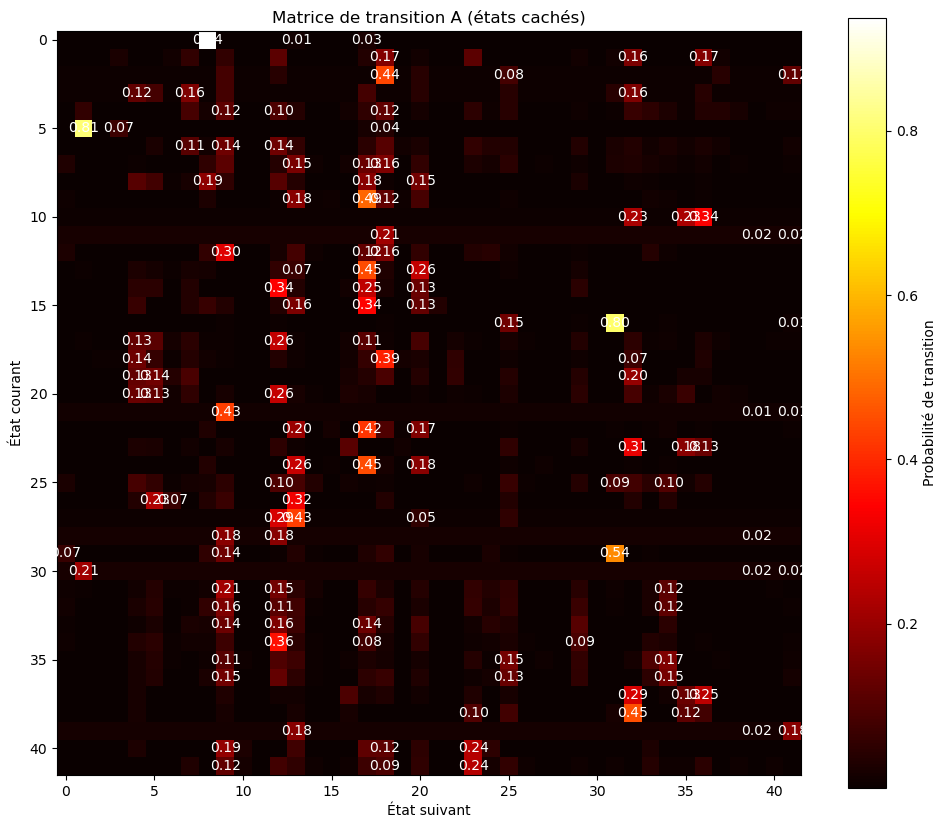

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Supposons que A est ta matrice de transition (N x N)
N = A.shape[0]

# Affichage de la matrice de transition A
plt.figure(figsize=(12, 10))
plt.imshow(A, cmap='hot', interpolation='nearest')
plt.colorbar(label='Probabilité de transition')
plt.title("Matrice de transition A (états cachés)")
plt.xlabel("État suivant")
plt.ylabel("État courant")

# Annoter les 3 transitions les plus probables par état
for i in range(N):
    top_transitions = np.argsort(A[i, :])[-3:][::-1]  # Indices des 3 plus grandes valeurs
    for j in top_transitions:
        plt.text(j, i, f"{A[i, j]:.2f}", ha='center', va='center', color='white')

plt.show()

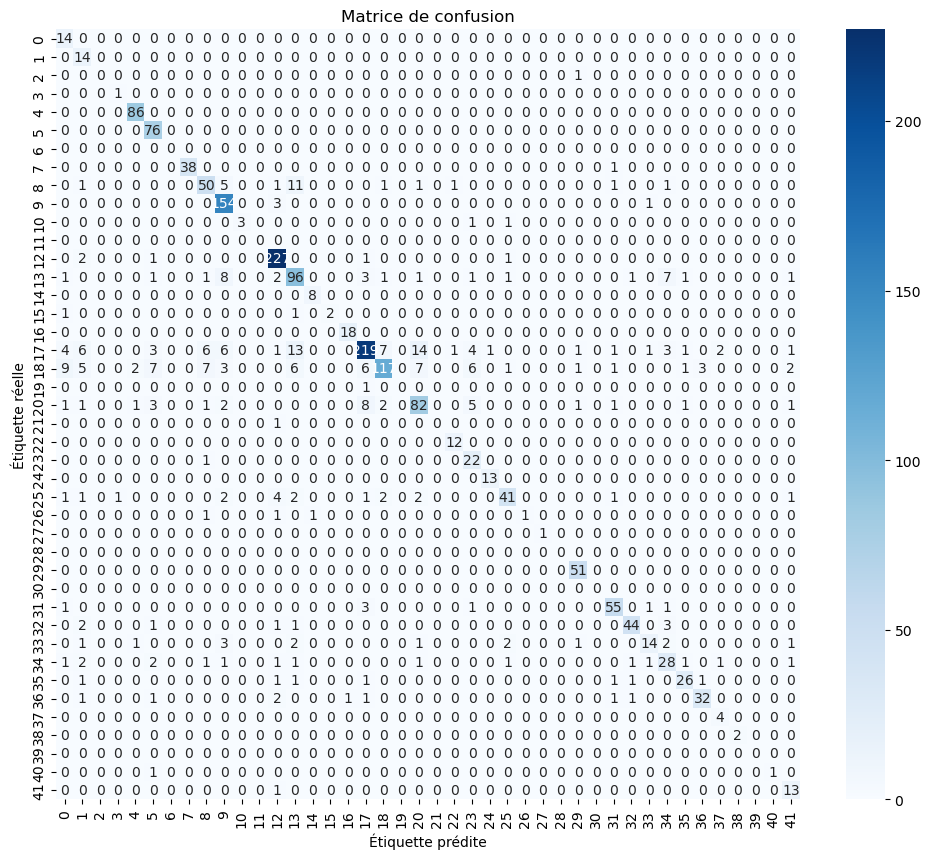

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collecte toutes les prédictions et étiquettes réelles
y_true = np.concatenate(allqT)  # Toutes les étiquettes réelles
y_pred = np.concatenate([viterbi(x, pi, A, B)[0] for x in allxT])  # Toutes les prédictions

# Calcule la matrice de confusion
cm = confusion_matrix(y_true, y_pred, labels=range(N))

# Affichage
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(N), yticklabels=range(N))
plt.title("Matrice de confusion")
plt.xlabel("Étiquette prédite")
plt.ylabel("Étiquette réelle")
plt.show()

In [50]:
# Exemples où Viterbi a corrigé des erreurs (S != allqT[i] mais proche)
for i in range(min(5, len(allxT))):  # Affiche les 5 premiers exemples
    S, _ = viterbi(allxT[i], pi, A, B)
    print(f"Exemple {i+1}:")
    print(f"  Observations: {allxT[i]}")
    print(f"  Étiquettes réelles: {allqT[i]}")
    print(f"  Étiquettes prédites: {S}")
    print(f"  Correction: {np.mean(np.array(S) == np.array(allqT[i])):.2f}")
    print("---")


Exemple 1:
  Observations: [4569, 2754, 4258, 4569, 2850, 4569, 2383, 4299, 4212, 1504, 3961, 4569, 2730, 4320, 2447, 2499, 1181, 13, 2244, 2499, 3724, 4304, 13, 4569, 4299, 3979, 1362, 4164, 2751, 2538, 851, 1494, 400, 11, 4569, 4569, 20]
  Étiquettes réelles: [17, 12, 9, 17, 36, 25, 34, 29, 31, 9, 13, 17, 12, 17, 20, 12, 18, 4, 13, 12, 17, 17, 4, 31, 29, 31, 9, 13, 17, 12, 18, 7, 18, 22, 13, 20, 5]
  Étiquettes prédites: [41. 12.  9. 17. 36. 25. 34. 29. 31.  9. 13. 20. 12. 17. 20. 12. 18.  4.
 13. 12.  9. 17.  4. 33. 29. 31.  9. 13. 17. 12. 18.  7. 18. 22. 13. 20.
  5.]
  Correction: 0.89
---
Exemple 2:
  Observations: [4569, 3251, 4258, 4569, 4569, 4569, 11, 4569, 1909, 4299, 1362, 2471, 4569, 3464, 2645, 2668, 4299, 4569, 1362, 4569, 2754, 4569, 3326, 4258, 3371, 4490, 20]
  Étiquettes réelles: [18, 12, 9, 18, 18, 18, 22, 34, 17, 29, 9, 17, 13, 17, 36, 34, 29, 31, 9, 17, 12, 17, 12, 9, 13, 17, 5]
  Étiquettes prédites: [41. 12.  9. 18. 18. 18. 22. 13. 17. 29.  9. 17.  5.  1. 36. 34

# 2) Conditional Random Fields (CRF)

**CRF are disciminative models** representing the conditional distribution $P( \mathbf{y} | \mathbf{x} , \mathbf{w})$:

$$ P( \mathbf{y} | \mathbf{x} , \mathbf{w})  = \frac{e^{\mathbf{w}^T  \psi(\mathbf{x},\mathbf{y}) } }{\sum\limits_{y' \in \mathcal{y}}e^{\mathbf{w}^T  \psi(\mathbf{x},\mathbf{y}') } } $$ 
        
**In 'linear-chain' CRFs**, the feature functions include **unary terms $u_k$** ($\sim$ $\mathbf{B}$ matrix in HMMs) and **pairwise terms $p_k$** ($\sim$ $\mathbf{A}$ matrix in HMMs):

$$ \mathbf{w}^T \psi(\mathbf{x},\mathbf{y}) = \sum\limits_{t=1}^T \sum_{k=1}^K F_k(y_{t-1}, y_t, \mathbf{x})  =   \sum\limits_{t=1}^T \sum_{k=1}^K \left[ u_k(y_t, \mathbf{x}) + p_k(y_{t-1}, y_t, \mathbf{x}) \right]$$

[<img src="https://thome.isir.upmc.fr/classes/RITAL/crf-obs2.png" width="800" >](https://thome.isir.upmc.fr/classes/RITAL/crf-obs2.png)


We can directly use resources from nltk: 
- [CRFTagger](https://tedboy.github.io/nlps/generated/generated/nltk.CRFTagger.html)
- [PerceptronTagger](https://www.nltk.org/_modules/nltk/tag/perceptron.html)

In [53]:
!pip install python-crfsuite --break-system-packages
from nltk.tag.crf import CRFTagger
tagger = CRFTagger()
tagger.train(alldocs, 'out/crf.model') # training

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 533.9 kB/s eta 0:00:00m eta 0:00:010:01:01


NameError: name 'pycrfsuite' is not defined

### Training and evaluating the model, as before

Check: 1720 bonnes réponses

In [ ]:
# perceptron
from nltk.tag.perceptron    import PerceptronTagger
tagger = PerceptronTagger(load=False)
tagger.train(alldocs)

Check: 1737 bonnes réponses

# Going further

- We test the application for PoS, we can run similar experiments for chunking (see parsing indication, very simple to load data)
- Run  experiement on the larger dataset. This dataset is still largely used in research. This work can thus be included in your resume :)
- Work will be purshed with word embeddings (next practical), and for [NER](https://www.clips.uantwerpen.be/conll2003/ner/) with RNNs (X. Tannier)
- [State-of-the-art resources](https://github.com/stanfordnlp/stanza/)